In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy as sp
import scipy.cluster.vq
import scipy.spatial.distance
import scipy.stats
import sklearn.cluster
from scipy.spatial.distance import cdist, pdist
import pylab as pl
%matplotlib inline

## Read in Data

In [2]:
data = pd.read_csv('FMADatasetTrans-cleaned.csv').drop('Unnamed: 0',axis=1)
response = pd.Series.from_csv('response.csv')

C:\Users\prern\Anaconda3\lib\site-packages\pandas\core\series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [3]:
response.value_counts()

Rock                   1997
Experimental           1344
Electronic             1258
Hip-Hop                 369
Folk                    339
Pop                     325
International           237
Classical               234
Instrumental            169
Spoken                  118
Old-Time / Historic      95
Jazz                     93
Soul-RnB                 39
Country                  32
Blues                    29
Easy Listening            4
dtype: int64

In [4]:
data['genre'] = response
data=data.loc[data['genre']!='Easy Listening'].reset_index(drop=True)
response = data['genre'].copy(deep=True)
data=data.drop('genre',axis=1)
response

0             Hip-Hop
1                 Pop
2                Rock
3                Rock
4                Rock
5                Rock
6                Rock
7                Rock
8                Rock
9                Rock
10               Rock
11               Rock
12               Rock
13               Rock
14               Rock
15               Rock
16               Rock
17               Rock
18               Rock
19               Rock
20               Rock
21               Rock
22               Rock
23               Rock
24               Rock
25               Rock
26               Rock
27               Rock
28         Electronic
29         Electronic
            ...      
6648     Experimental
6649     Experimental
6650     Experimental
6651     Experimental
6652     Experimental
6653     Experimental
6654     Experimental
6655     Experimental
6656     Experimental
6657       Electronic
6658       Electronic
6659    International
6660    International
6661    International
6662    In

In [5]:
le = LabelEncoder() #encode variables so that they can be put into a model
responseEncoded = le.fit_transform(response)
responseEncoded

array([ 6, 11, 12, ...,  5,  5,  5], dtype=int64)

In [6]:
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(data,responseEncoded,test_size=.4)

## Visualizing Dataset in 2D

In [7]:
def plotClasses2D(X,y,dimensionality_reduction='PCA',title=None):
    '''
    Use this to visualize the separation of classes in two dimensions.'''
    if dimensionality_reduction=='PCA':
        pca = PCA(n_components=2) #two dimensions to plot on two dimensions
        xPlot = pca.fit_transform(X)
    elif dimensionality_reduction=='TSNE':
        tsne = TSNE(n_components=2)
        xPlot = tsne.fit_transform(X)
    else:
        xPlot=X
    df = pd.DataFrame(xPlot)
    if len(df.columns)!=2:
        return "DimError: Can't plot data not in two dimensions"
    df['y'] = y
    plt.figure()
    for label in df['y'].unique():
        sns.regplot(df[0].loc[df['y']==label],df[1].loc[df['y']==label],fit_reg=False,label=label)
        plt.legend(bbox_to_anchor=(1.1,1.05))
        if title!=None:
            plt.title(title)

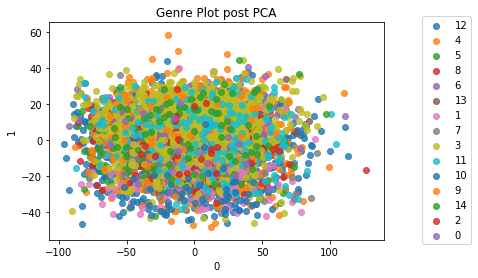

In [8]:
plotClasses2D(X_train,y_train,title='Genre Plot post PCA') #pca

## Baseline K-Means

In [ ]:
def ssq_statistics(data, ks=range(1,11), ssq_norm=True):
    """Computes the sum of squares for an nxm dataset.

    The sum of squares (SSQ) is a measure of within-cluster variation that measures the sum of 
    squared distances from cluster prototypes.

    Each computation of the SSQ requires the clustering of the input dataset. To identify the 
    optimal number of clusters k, the SSQ is computed over a range of possible values of k 
    (via the parameter ks). For each value of k, within-cluster dispersion is calculated for the 
    input dataset.

    The estimated optimal number of clusters, then, is defined as the value of k prior to an
    "elbow" point in the plot of SSQ values.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      ssqs: an array of SSQs, one computed for each k.

    """
    ssqs = sp.zeros((len(ks),)) # array for SSQs (lenth ks)

    #n_samples, n_features = data.shape # the number of rows (samples) and columns (features)
    #if n_samples >= 2500:
    #    # Generate a small sub-sample of the data
    #    data_sample = shuffle(data, random_state=0)[:1000]
    #else:
    #    data_sample = data

    for (i,k) in enumerate(ks): # iterate over the range of k values        
        # Fit the model on the data
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(data)

        # Predict on the data (k-means) and get labels
        #labels = kmeans.predict(data)

        if ssq_norm:
            dist = np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)

            tot_withinss = sum(dist**2) # Total within-cluster sum of squares
            totss = sum(pdist(data)**2) / data.shape[0] # The total sum of squares
            betweenss = totss - tot_withinss # The between-cluster sum of squares
            ssqs[i] = betweenss/totss*100
        else:
            # The sum of squared error (SSQ) for k
            ssqs[i] = kmeans.inertia_

    return ssqs

def plot_ssq_statistics(ssqs):
    """Generates and shows plots for the sum of squares (SSQ).

    A figure with one plot is generated. The plot is a bar plot of the SSQ computed for each 
    value of k.

    Args:
      ssqs (SciPy array): An array of SSQs, one computed for each k.

    """
    # Create a figure
    fig = pl.figure(figsize=(6.75, 4))

    ind = range(1,len(ssqs)+1) # the x values for the ssqs
    width = 0.5 # the width of the bars

    # Create a bar plot
    #rects = pl.bar(ind, ssqs, width)
    pl.plot(ind, ssqs)

    # Add figure labels and ticks
    pl.title('Clustering Sum of Squared Distances', fontsize=16)
    pl.xlabel('Number of clusters k', fontsize=14)
    pl.ylabel('Sum of Squared Distance (SSQ)', fontsize=14)
    pl.xticks(ind)

    # Add text labels
    #for rect in rects:
    #    height = rect.get_height()
    #    pl.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d' % int(height), \
    #            ha='center', va='bottom')

    # Add figure bounds
    pl.ylim(0, max(ssqs)*1.2)
    pl.xlim(0, len(ssqs)+1.0)

    pl.show()

In [ ]:
ssq=ssq_statistics(data, ks=range(1,30+1))
plot_ssq_statistics(ssq)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## Gaussian Mixture Models

In [9]:
responseEncoded

array([ 6, 11, 12, ...,  5,  5,  5], dtype=int64)

In [10]:
data.head()

,acousticness,danceability,energy,instrumentalness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,...,tonnetz.37,tonnetz.38,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.6
0,-0.695041,0.682179,0.634544,-1.215102,-2.468293,0.642706,0.575714,0.582495,0.471984,0.508989,...,-1.918384,-1.046551,-1.561353,-1.755760,-1.530469,-8.973411,0.354692,-1.950820,-2.151796,-1.723735
1,-0.760227,0.521350,0.817554,-1.239133,-0.839564,0.479206,0.267598,0.582495,0.471984,0.508989,...,-1.408139,-1.020470,-1.145736,-1.475555,-1.571847,-6.368528,0.434410,-1.681186,-1.761941,-1.803182
2,-0.043759,0.662830,0.924633,-0.030882,-8.062676,0.414608,0.963518,0.834591,0.749667,1.000000,...,-1.734801,-1.081774,-0.893442,-1.532135,-1.298345,-13.384400,0.209889,-1.981206,-2.011986,-2.208358
3,-0.642571,0.504525,0.560467,-1.194809,-0.678925,0.426055,0.893843,0.582495,0.471984,0.508989,...,-1.299278,-0.527856,-0.971555,-1.192269,-1.172752,-5.568277,0.266398,-2.469772,-2.578564,-2.500909
4,-1.301601,0.228931,0.607130,-0.164302,-8.809239,0.772947,0.158379,0.582395,0.403694,0.508901,...,-1.661267,-1.367831,-1.443515,-1.800587,-1.600945,-6.299742,0.330474,-2.112630,-2.159863,-2.296970


In [11]:
data.describe()

,acousticness,danceability,energy,instrumentalness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,...,tonnetz.37,tonnetz.38,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.6
count,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,...,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000,6678.000000
mean,-0.655059,0.464515,0.533720,-0.381239,-5.449542,0.462964,0.432408,0.472425,0.348097,0.425956,...,-1.526172,-1.012456,-1.012153,-1.391610,-1.303579,-8.466296,0.343713,-2.004327,-2.168520,-1.987358
std,0.647306,0.207542,0.284034,0.433104,2.488815,0.149186,0.278106,0.177064,0.157611,0.172470,...,0.302181,0.269736,0.281613,0.230257,0.202292,3.035046,0.175313,0.362773,0.399215,0.507791
min,-1.824525,0.000000,0.000000,-1.245698,-18.347645,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.203485,-2.217105,-2.305373,-3.081377,-2.471821,-17.991609,0.000000,-3.997661,-4.383486,-4.860685
25%,-1.224663,0.309580,0.311093,-0.599975,-7.161640,0.345711,0.186005,0.376032,0.243065,0.328593,...,-1.727540,-1.200190,-1.205300,-1.546515,-1.438049,-10.734447,0.215439,-2.226341,-2.416111,-2.323518
50%,-0.407976,0.456524,0.544734,-0.147295,-5.623321,0.450440,0.408184,0.482596,0.346278,0.421696,...,-1.539892,-1.017949,-1.016266,-1.405209,-1.314499,-8.493709,0.326942,-1.992356,-2.159863,-2.002658
75%,-0.059897,0.616158,0.778849,-0.074003,-3.801965,0.559689,0.659510,0.615795,0.441789,0.557192,...,-1.333589,-0.829801,-0.819347,-1.246142,-1.179478,-6.230213,0.433905,-1.782899,-1.916183,-1.650623
max,0.001000,1.000000,1.000000,0.001000,0.000999,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.000999,1.000000,0.001000,0.001000,0.001000


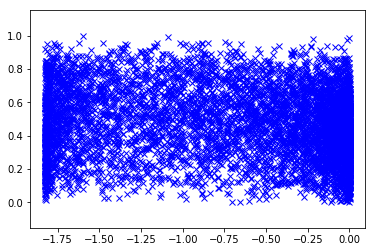

In [12]:
plt.plot(data.iloc[:,0], data.iloc[:,1], 'bx')
plt.axis('equal')
plt.show()

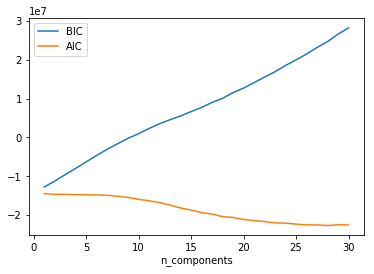

In [17]:
n_components = np.arange(1, 31)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data)
          for n in n_components]

plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [13]:
reducedDf = pd.read_csv('FMADataset-reduced-with-pca.csv')

In [14]:
reducedDf.head()

,Unnamed: 0,0,1,2,3,4,5,6
0,0,60.587093,13.525421,6.449218,10.029388,4.010357,4.867053,2.092079
1,1,29.202348,-4.947352,4.182831,25.509447,1.183777,-2.958087,-2.579002
2,2,-25.704546,12.391144,5.863817,-0.529203,-8.526611,-5.371546,-7.365762
3,3,16.925889,-26.848047,-7.041860,-3.180312,0.226964,-2.598133,1.994784
4,4,-2.035927,-0.554280,-16.761623,-7.882677,-0.832575,10.548632,-7.882884


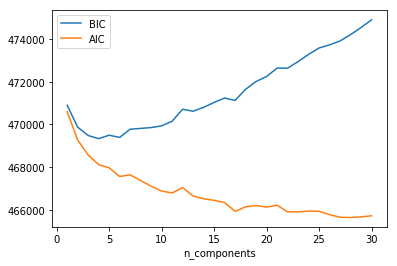

In [15]:
n_components = np.arange(1, 31)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reducedDf)
          for n in n_components]

plt.plot(n_components, [m.bic(reducedDf) for m in models], label='BIC')
plt.plot(n_components, [m.aic(reducedDf) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

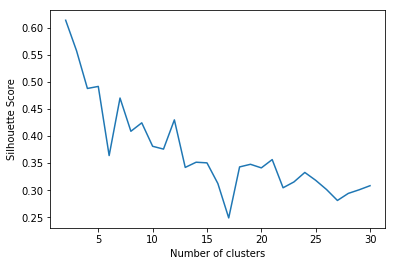

In [31]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        #kmeans = sklearn.cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
        gmm = GaussianMixture(n_components=k,random_state=0).fit(reducedDf)
        #kmeans.fit_predict(X)
        preds = gmm.predict(reducedDf)
        s[k] = silhouette_score(X,preds,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
sc_evaluate_clusters(reducedDf,30)

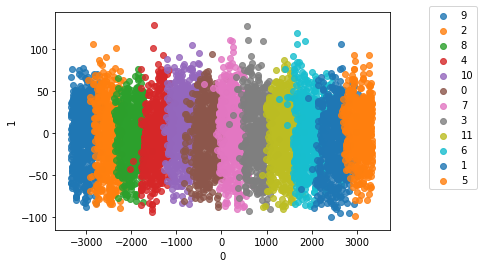

In [33]:
gmm = GaussianMixture(n_components=12,random_state=0).fit(reducedDf)
prediction = gmm.predict(reducedDf)
plotClasses2D(reducedDf,prediction,dimensionality_reduction='PCA',title=None)

In [ ]:
ssq=ssq_statistics(reducedDf, ks=range(1,30+1))
plot_ssq_statistics(ssq)

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')